In [62]:
import numpy as np
import pandas as pd
import csv
import urllib
from urllib.request import Request, urlopen
import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud

RAW_DATA_PATH = '../../data/raw/'
PROCESSED_DATA_PATH = '../../data/processed/'

# Raw news contents pipeline
- Download
- Cleaning
- Topic modelling

## Download

In [ ]:
# scrape from a list of urls
# and download news!
gdeltdata = './20200622073000.export.CSV'

reader = csv.reader(open(gdeltdata),
                    delimiter='\t')
counter = 0
with open('news_raw_contents.csv', 'w', newline='') as csvfile:
    newswriter = csv.writer(csvfile, delimiter='|')
    
    
    for row in reader:
        #print (row[40:42],row[44],row[-1])
        if counter < 225:
            counter+=1
            continue
        url = row[-1]
        print(counter)

        try:
            req = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
            resp = urlopen(req)
            respData = resp.read()

            paragraphs = re.findall(r'<p>(.*?)</p>',str(respData))
            rawtext=''
            for eachP in paragraphs:
                rawtext+=eachP.replace("|", " ")
            newswriter.writerow([row[0],row[40],row[41],row[44],rawtext])
        except urllib.request.HTTPError as e:
            print(url)
        except Exception as e:
            print(f"Unexpected error {e} at {url}")
        counter +=1
#         if counter > 2:
#             break

In [60]:
unique_src = pd.read_csv('climate_change_us.csv').source.unique()

In [61]:
len(unique_src)

19148

In [63]:
unique_src[0:20]

array(['forimmediaterelease.net', 'valuewalk.com', 'news957.com',
       'news12.com', 'sfgate.com', 'prnewswire.com', 'lexology.com',
       'myjournalcourier.com', 'mercurynews.com', 'wfsu.org', 'ksgf.com',
       'thegardnernews.com', 'greensboro.com', 'bigislandnow.com',
       'southwhidbeyrecord.com', 'presstelegram.com', 'lmtonline.com',
       'newsadvance.com', 'sgvtribune.com', 'wect.com'], dtype=object)

## Cleaning

In [4]:
df = pd.read_csv(RAW_DATA_PATH + 'raw_climate_news_us_aa.csv',delimiter='|',header=None,names=['timestamp','domain','url','rawtext'])

In [5]:
#clean the null html contents
df = df[df.rawtext.notnull()]

In [6]:
def soup_get_text(html):
    soup = BeautifulSoup(html, 'html.parser')
    txt = soup.get_text()
    return txt

In [7]:
def find_index_by_keywords(txt,keywords=['climate']):
    for kw in keywords:
        idx = txt.find(kw)
        if idx > 0:
            return idx
    return idx

In [8]:
df['pure_text'] = df['rawtext'].map(lambda x: soup_get_text(x))

In [9]:
df['first_climate_word'] = df['pure_text'].map(lambda x:find_index_by_keywords(x,['climate']))

In [10]:
df_climate = df.query('first_climate_word > 0')
df_climate['climate_sentence'] = df_climate['pure_text'].map(lambda x: re.findall(r"([^.]*?climate[^.]*\.)",x) )

<ipython-input-10-2c3b317c9c2f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_climate['climate_sentence'] = df_climate['pure_text'].map(lambda x: re.findall(r"([^.]*?climate[^.]*\.)",x) )


In [13]:
df_climate[['timestamp','domain','url','climate_sentence']].to_csv(PROCESSED_DATA_PATH+'climate_us_aa_sentence.csv')

In [10]:
df_climate['climate_sentence']

0        [ Findings of the study should be good news fo...
1        [OTTAWA – Prime Minister Justin Trudeau has sp...
3        [Adaptive reuse of the existing property will ...
4        [ In a controversial decision, the FAC argued ...
5        [His policy work has included climate change, ...
                               ...                        
59455    [Attorney General Barbara Underwood has filed ...
59457    [com researched Facebook and Twitter accounts ...
59459    [\xe2\x80\x9dThe book tackles a variety of iss...
59461    [ Tom CarperThomas (Tom) Richard CarperOVERNIG...
59462    [Infrastructure, access to the internet and cl...
Name: climate_sentence, Length: 30283, dtype: object

In [29]:
#debugging
#single run
sample_pure_text = df.query('first_climate_word > 0').iloc[0]['pure_text']

re.findall(r"([^.]*?climate[^.]*\.)",sample_pure_text) 

### Notes on aa result
0:Findings of the study should be good news for conservationists worried about habitat loss and climate change speeding up animal extinctions

1:Prime Minister Justin Trudeau has spoken to German Chancellor Angela Merkel about making progress on climate change and combating protectionism when they meet at the G7 next month in Quebec

2:NA

3:Uhaul climate-controlled

4: In a controversial decision, the FAC argued that the negative consequences originating from climate change (especially the high carbon dioxide emissions) possess greater weight than the public benefits of the major airport expansion.

5:His policy work has included climate change, health care, infrastructure, mental health and disability rights.

6:NA
7:NA
8:NA

# Topic modeling
Prototyping topic modeling code, implemented functions:

- Word clould

In [11]:

all_str_list = []
for sentence_list in df_climate['climate_sentence']:
    for sentence in sentence_list:
        all_str_list.append(sentence)


In [17]:
import unicode

ModuleNotFoundError: No module named 'unicode'

In [29]:
tagRe = re.compile(r'[\x00-\x1F]+')

In [30]:
tagRe.sub('', "\\xe2\\x80\\x98i")

'\\xe2\\x80\\x98i'

In [40]:
mystring = "\\xe2\\x80\\x98i"

In [41]:
mystring

'\\xe2\\x80\\x98i'

In [56]:
def regex_clean(raw_str):
    cleaned_str = re.sub(r'\\x\w\w', '', raw_str)
    return re.sub(r"[^a-zA-Z' ]+", '', cleaned_str)

In [57]:
cleaned_all_str = [regex_clean(raw_str) for raw_str in all_str_list]

In [58]:
len(cleaned_all_str)

106538

In [48]:
re.sub(r'\\x\w*', '', mystring)

''

In [37]:
print('\xa0')

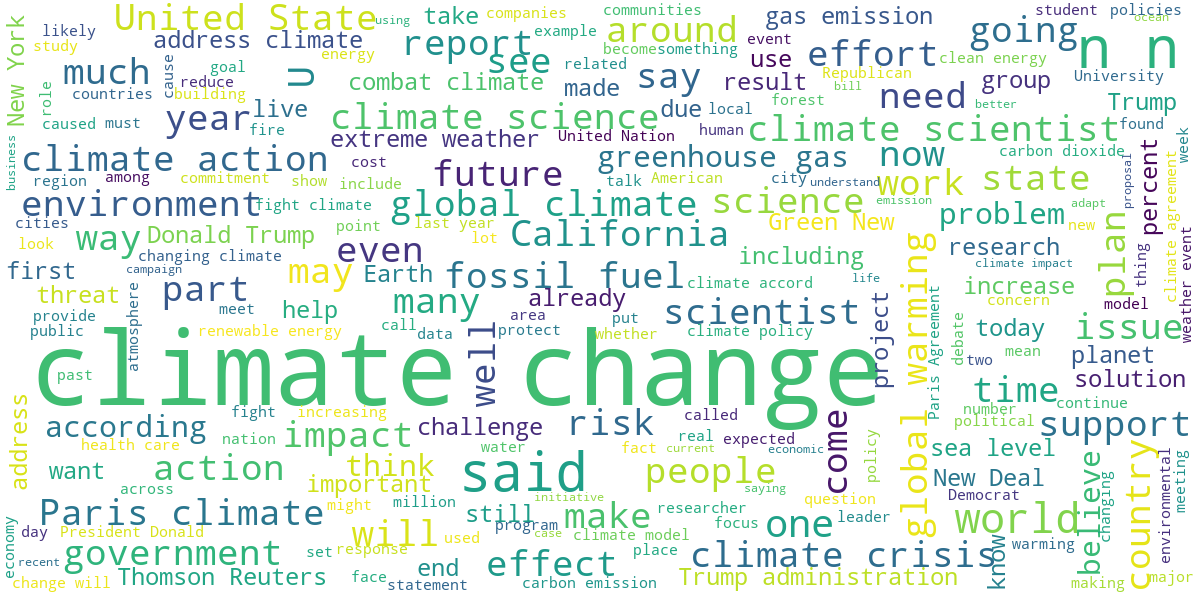

In [67]:
#explorative analysis

str_corpus = ','.join(cleaned_all_str)
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',scale=3)# Generate a word cloud
wordcloud.generate(str_corpus)# Visualize the word cloud
wordcloud.to_image()

In [68]:
wordcloud.to_file(PROCESSED_DATA_PATH+'cc_sentence_wordcloud.png')

In [24]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/liuz/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)print(data_words[:1][0][:30])